# Analyzing Political Rhetoric in the 2024 U.S. Election

In this notebook, we will scrape political speeches from trustworthy sources related to the 2024 U.S. presidential election. We will perform sentiment analysis, topic modeling, and visualize our findings to gain insights into the candidates' rhetoric.

## Import Necessary Libraries

In [27]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
from gensim import corpora, models
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import pyLDAvis.gensim_models
import warnings

warnings.filterwarnings('ignore')

# Download NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simonbeckmann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonbeckmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scrape Political Speeches

We will scrape speeches from candidates' official websites and reputable news outlets. Please ensure that scraping these websites complies with their terms of service.

In [28]:
from youtube_transcript_api import YouTubeTranscriptApi
import pandas as pd

# Function to get transcripts using video IDs
def get_youtube_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        # Combine all text into one
        return " ".join([item['text'] for item in transcript])
    except Exception as e:
        print(f"Could not retrieve transcript for video {video_id}: {e}")
        return None

# Dictionary with video IDs
candidate_videos = {
    'Kamala Harris': '61HY9atD2H4',  # Harris DNC 2024 full speech video ID
    'Donald Trump': 'dLUK_MEJP_M',   # Trump RNC 2024 full speech video ID
    'Donald Trump NYC': '23a30db5-11b1-44df-94d9-8dba172a0966'  # Example ID
}

# Retrieve and store transcripts
all_speeches = []
for candidate, video_id in candidate_videos.items():
    print(f"Retrieving transcript for {candidate}...")
    speech_text = get_youtube_transcript(video_id)
    if speech_text:
        all_speeches.append({'candidate': candidate, 'speech': speech_text})

# Create DataFrame
if all_speeches:
    df = pd.DataFrame(all_speeches)

    # Define a cleaning function
    def clean_text(text):
        text = text.replace('\n', ' ')
        text = text.replace('\r', ' ')
        text = ' '.join(text.split())
        return text

    # Apply the cleaning function
    df['clean_speech'] = df['speech'].apply(clean_text)
    print(df.head())
else:
    print("No transcripts retrieved. Please check video IDs.")


Retrieving transcript for Kamala Harris...
Retrieving transcript for Donald Trump...
Retrieving transcript for Donald Trump NYC...
Could not retrieve transcript for video 23a30db5-11b1-44df-94d9-8dba172a0966: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=23a30db5-11b1-44df-94d9-8dba172a0966! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
       candidate                                             speech  \
0  Kamala Harris  thank you thank you please thank you please th...   
1   Donald Trump  [Applause] thank you very much th

## Data Cleaning

We need to clean the speech texts by removing unwanted characters, headers, and footers.

In [29]:
# Define a cleaning function
def clean_text(text):
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = ' '.join(text.split())
    return text

# Apply the cleaning function
df['clean_speech'] = df['speech'].apply(clean_text)
df.head()

,candidate,speech,clean_speech
0,Kamala Harris,thank you thank you please thank you please th...,thank you thank you please thank you please th...
1,Donald Trump,[Applause] thank you very much thank you very ...,[Applause] thank you very much thank you very ...


## Sentiment Analysis

We will use TextBlob to perform sentiment analysis on the speeches.

In [30]:
# Function to calculate sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the sentiment function
df[['polarity', 'subjectivity']] = df['clean_speech'].apply(lambda x: pd.Series(get_sentiment(x)))
df.head()

,candidate,speech,clean_speech,polarity,subjectivity
0,Kamala Harris,thank you thank you please thank you please th...,thank you thank you please thank you please th...,0.161371,0.503254
1,Donald Trump,[Applause] thank you very much thank you very ...,[Applause] thank you very much thank you very ...,0.178675,0.509868


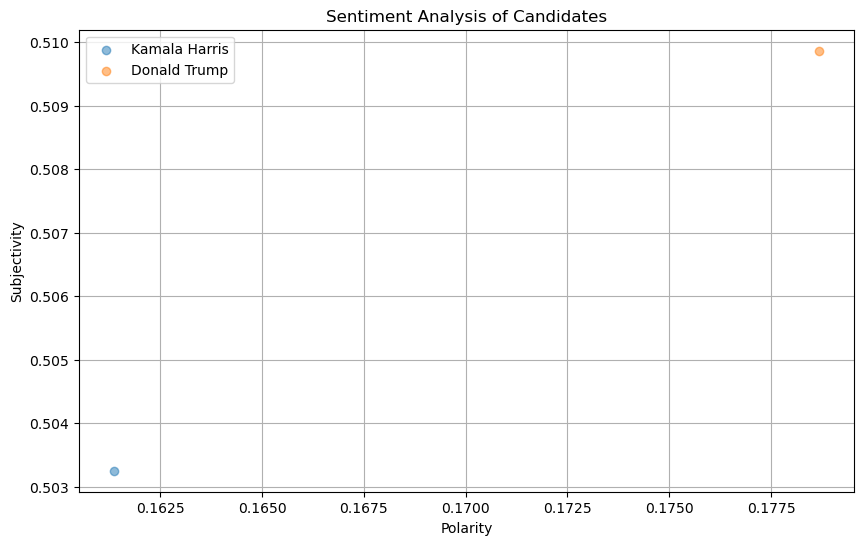

In [31]:
# Plot sentiment
plt.figure(figsize=(10, 6))
for candidate in df['candidate'].unique():
    subset = df[df['candidate'] == candidate]
    plt.scatter(subset['polarity'], subset['subjectivity'], alpha=0.5, label=candidate)
plt.title('Sentiment Analysis of Candidates')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.legend()
plt.grid(True)
plt.show()

## Generate Word Clouds

Visualize the most frequent words used by each candidate.

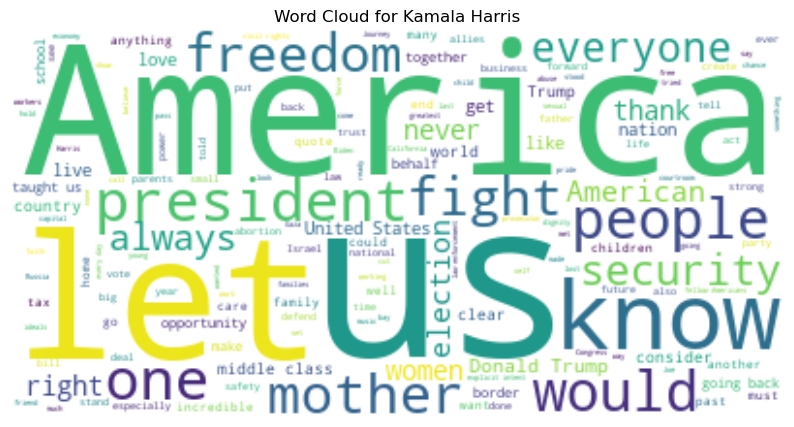

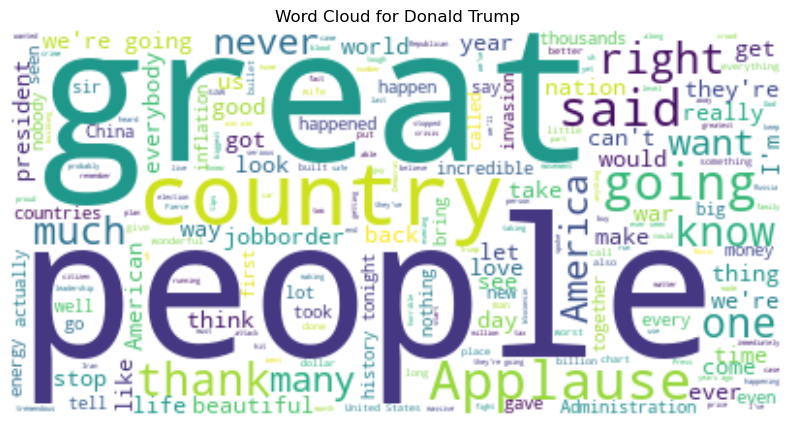

In [32]:
# Generate word clouds
stop_words = set(stopwords.words('english'))

for candidate in df['candidate'].unique():
    text = ' '.join(df[df['candidate'] == candidate]['clean_speech'])
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {candidate}')
    plt.show()

## Topic Modeling

We will use LDA (Latent Dirichlet Allocation) to identify topics within the speeches.

In [37]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set the NLTK data path explicitly (optional: specify a path on your system)
nltk.data.path.append('/Users/simonbeckmann/Textgeneration/NLP/NLTK-data')

# Download necessary NLTK resources
nltk.download('punkt', download_dir='/usr/local/share/nltk_data')
nltk.download('stopwords', download_dir='/usr/local/share/nltk_data')

# Define stop words
stop_words = set(stopwords.words('english'))

# Preprocess function
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply preprocessing
df['tokens'] = df['clean_speech'].apply(preprocess)
df.head()


[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...


PermissionError: [Errno 13] Permission denied: '/usr/local/share/nltk_data'

In [ ]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Build LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

KeyError: 'tokens'

In [ ]:
# Display topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
# Visualize the topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Conclusion

We have successfully scraped political speeches, performed sentiment analysis, generated word clouds, and conducted topic modeling to analyze the rhetoric of the 2024 U.S. presidential candidates.